# Práctica 9 

### TDM - Máster en IoT - Rafael Caballero

El periódico [El País](https://elpais.com/espana/2022-01-10/consulte-todos-los-datos-internos-de-la-encuesta-de-el-pais-cuestionarios-cruces-y-respuestas-individuales.html) ha publicado estos días en abierto los datos de 2000 encuestas utilizados para estudiar la intención de voto. Además del partido al que cada persona indica que votaría se incluyen datos personales como edad, situación laboral, etc, y la respuesta a un cuestionario para entender mejor el perfil de voto a cada partido.

Aquí vamos a fijarnos en los datos correspondientes a los que indican que en las pasadas elecciones votaron a los partidos "CS","PP","PSOE","UP" y "VOX", dato que aparece en la columna label ("CS"-->0,....,"VOX"-->5)

### Setup

In [1]:
import os.path
from subprocess import check_call
import importlib
import os
import sys
import findspark
import pyspark  # only run after findspark.init()
from pyspark.sql import SparkSession

modules = ["findspark", "pyspark"]


def check_modules(modules, upgrade=False):
    print("Checking required modules")
    for m in modules:
        torch_loader = importlib.util.find_spec(m)
        if torch_loader is not None and not upgrade:
            print(m, " found")
        else:
            if upgrade:
                print("upgrading ", m)
            else:
                print(m, " not found, installing")
            if "google.colab" in sys.modules:
                if upgrade:
                    check_call(["pip", "install", "--upgrade", m])
                else:
                    check_call(["pip", "install", "-q", m])
            else:
                if upgrade:
                    check_call(
                        [
                            sys.executable,
                            "-m",
                            "pip",
                            "install",
                            "--user",
                            "--upgrade",
                            m,
                        ]
                    )
                else:
                    check_call([sys.executable, "-m", "pip", "install", "--user", m])


if "google.colab" in sys.modules:
    !apt-get install openjdk-8-jdk-headless -qq > /dev/null
    spark = "spark-3.2.0-bin-hadoop3.2.tgz"
    if not os.path.isfile(spark):
        !wget -q https://downloads.apache.org/spark/spark-3.2.0/{spark}
        !tar xf {spark}
        os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
        os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

check_modules(modules, upgrade=False)

findspark.init()
spark = SparkSession.builder.getOrCreate()  # SparkSession.builder.getOrCreate()
sc = spark.sparkContext
df = spark.sql("""select 'spark' as hi """)
df.show()

Checking required modules
findspark  found
pyspark  found


24/11/26 19:04:02 WARN Utils: Your hostname, ubuntu resolves to a loopback address: 127.0.1.1; using 10.9.107.102 instead (on interface wlp0s20f3)
24/11/26 19:04:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/26 19:04:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+-----+
|   hi|
+-----+
|spark|
+-----+



Solo por si alguien necesita poner las variables manualmente desde Python

In [2]:
"""
%matplotlib inline
import os
# descargar la carpeta copiar la carpeta spark en c:\hlocal\tdm
import os
# cambiamos las variables del sistema
spark = 'C:/hlocal/tdm/spark/spark-3.0.1-bin-hadoop3.2'

if not(os.path.isdir(spark+"/bin")) or not(os.path.isdir(spark+"/jars")) :
    print("Error, la carpeta en 'spark' debe contener los directorios bin y jars ")
else:
    # en el path se añade
    #path = os.environ.get('PATH')
    #path = path+ ';'+spark+'\\bin;'
    #os.environ['PATH'] = path
    os.environ['SPARK_HOME']= spark
    os.environ['HADOOP_HOME']= spark
    os.environ['PYSPARK_DRIVER_PYTHON']= 'jupyter'
    os.environ['PYSPARK_DRIVER_PYTHON_OPTS']='notebook'

    # si da problema quizás haya que poner java_home a la localización de java 8
    #os.environ['JAVA_HOME']= 'C:\\Program Files\\Java\\jdk1.8.0_151'
    #os.environ['PATH'] = os.environ.get('JAVA_HOME')+'\\bin;'+spark
    print("Hecho")
"""

<>:1: SyntaxWarning: invalid escape sequence '\h'
<>:1: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_3659134/3755441975.py:1: SyntaxWarning: invalid escape sequence '\h'
  """


'\n%matplotlib inline\nimport os\n# descargar la carpeta copiar la carpeta spark en c:\\hlocal\tdm\nimport os\n# cambiamos las variables del sistema\nspark = \'C:/hlocal/tdm/spark/spark-3.0.1-bin-hadoop3.2\'\n\nif not(os.path.isdir(spark+"/bin")) or not(os.path.isdir(spark+"/jars")) :\n    print("Error, la carpeta en \'spark\' debe contener los directorios bin y jars ")\nelse:\n    # en el path se añade\n    #path = os.environ.get(\'PATH\')\n    #path = path+ \';\'+spark+\'\\bin;\'\n    #os.environ[\'PATH\'] = path\n    os.environ[\'SPARK_HOME\']= spark\n    os.environ[\'HADOOP_HOME\']= spark\n    os.environ[\'PYSPARK_DRIVER_PYTHON\']= \'jupyter\'\n    os.environ[\'PYSPARK_DRIVER_PYTHON_OPTS\']=\'notebook\'\n\n    # si da problema quizás haya que poner java_home a la localización de java 8\n    #os.environ[\'JAVA_HOME\']= \'C:\\Program Files\\Java\\jdk1.8.0_151\'\n    #os.environ[\'PATH\'] = os.environ.get(\'JAVA_HOME\')+\'\\bin;\'+spark\n    print("Hecho")\n'

Algunas funciones auxiliares

In [3]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import numpy as np


import matplotlib.pyplot as plt

%matplotlib inline
from pyspark_dist_explore import hist
import pyspark.sql.functions as func


def load_file(file):
    df = (
        spark.read.format("com.databricks.spark.csv")
        .options(header="true", inferschema="true")
        .load(file)
    )
    return df


def evaluate_predictions(predictions, verb=True):
    preds_and_labels = predictions.select(["prediction", "label"])
    pl = preds_and_labels.rdd.map(tuple)
    metrics = MulticlassMetrics(pl)
    cm = metrics.confusionMatrix()

    #
    class_temp = (
        predictions.select("label")
        .groupBy("label")
        .count()
        .sort("count", ascending=False)
        .toPandas()
    )
    class_names = class_temp["label"].values.tolist()

    # print(class_names)
    cm = cm.toArray()
    if verb:
        print(cm)
    # add by rows to compute the recall
    sumaf = []
    if verb:
        print("Recall ")
    for i in range(len(class_names)):
        suma = sum(cm[i])
        if verb:
            print(i, ":", round(cm[i][i] / suma, 2))
        sumaf.append(suma)

    # add by columns to compute the precision
    sumac = []
    sumad = []
    if verb:
        print("Precision ")
    for i in range(len(class_names)):
        suma = 0
        for j in range(len(class_names)):
            suma += cm[j][i]
        sumac.append(suma)
        if verb:
            print(i, ":", round(cm[i][i] / suma, 2))
        sumad.append(cm[i][i])
    oa = np.sum(sumad) / sum(sumac)
    ac = 0
    for i in range(len(sumac)):
        ac += sumac[i] * sumaf[i]
    ac /= sum(sumac) * sum(sumac)
    # print(oa,ac)
    kappa = (oa - ac) / (1 - ac)
    if verb:
        print("***Global Statistics***")
        print("kappa ", round(kappa, 3))
        acc = pl.filter(lambda x: x[0] == x[1]).count() / float(pl.count())
        print("Model accuracy: %.3f%%" % (acc * 100))
    return cm, kappa


24/11/26 19:04:18 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Cargamos el fichero

In [4]:
url = "https://raw.githubusercontent.com/RafaelCaballero/tdm/master/datos/datav.csv"
file = "./datav.csv"

import urllib.request

f = urllib.request.urlretrieve(
    url, file
)  # in case of error download manually and comment this line
# lo cargamos como un dataframe
df = load_file(file)
print(f"{df.count()} rows")
df.printSchema()

730 rows
root
 |-- sex: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- hab: integer (nullable = true)
 |-- prov: integer (nullable = true)
 |-- ccaa: integer (nullable = true)
 |-- edu: integer (nullable = true)
 |-- cs: integer (nullable = true)
 |-- p1_1: integer (nullable = true)
 |-- p1_2: integer (nullable = true)
 |-- p1_3: integer (nullable = true)
 |-- p1_4: integer (nullable = true)
 |-- p1_5: integer (nullable = true)
 |-- p1_6: integer (nullable = true)
 |-- p1_7: integer (nullable = true)
 |-- p1_8: integer (nullable = true)
 |-- p1_9: integer (nullable = true)
 |-- p1_10: integer (nullable = true)
 |-- p2_1: integer (nullable = true)
 |-- p2_2: integer (nullable = true)
 |-- p2_3: integer (nullable = true)
 |-- p3_1: integer (nullable = true)
 |-- p3_2: integer (nullable = true)
 |-- p3_3: integer (nullable = true)
 |-- p3_4: integer (nullable = true)
 |-- p3_5: integer (nullable = true)
 |-- p3_6: integer (nullable = true)
 |-- p4_1: integer (nullable 

#### Ejercicio 1 (2 puntos). 

Lo primero que vamos a ver es si los datos de los participantes se pueden agrupar en 5 agregados de forma que cada uno represente (más o menos) a un partido político, es decir, si las preguntas y respuestas sirven para representar de forma natural las distintas opciones.

Para ellos vamos a utilizar k-means con k=5:

In [5]:
from pyspark.ml.clustering import KMeans

k = 5  # number of clusters (groups)
method = KMeans().setK(k).setSeed(1)  # don't change this!!

Este `method` será el segundo paso de un pipeline. El primer paso será el habitual VectorAssembler que agrupa en una columna `features` todas las columnas salvo `label` (que, al estar en aprendizaje no supervisado, no vamos a utilizar de momento).

Escribir el pipeline y aplicarlo al conjunto df, dejando el resultado en una variable `predictions`

*Importante*: aquí no hace falta dividir en train y test: tanto el *fit* como el *transform* se aplican a todo el dataframe

In [8]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

### solution
assembler = VectorAssembler(inputCols=df.columns[:-1], outputCol="features")
pipeline = Pipeline(stages=[assembler, method])
model = pipeline.fit(df)
predictions = model.transform(df)

24/11/26 19:12:02 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/11/26 19:12:03 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


La columna `prediction` es un número de 0 a 4; las filas que tengan el mismo número se entiende que están en el mismo cluster. Estos valores no tienen por qué coinciden con la etiqueta `label`, que no se ha utilizado aun, como podemos ver:

In [9]:
predictions.select("label", "prediction").show()

+-----+----------+
|label|prediction|
+-----+----------+
|    3|         1|
|    0|         0|
|    2|         3|
|    0|         0|
|    1|         4|
|    1|         3|
|    2|         3|
|    3|         3|
|    0|         4|
|    1|         3|
|    0|         4|
|    4|         3|
|    4|         4|
|    3|         4|
|    1|         1|
|    4|         1|
|    0|         3|
|    1|         4|
|    4|         2|
|    3|         3|
+-----+----------+
only showing top 20 rows



#### Ejercicio 2  (2 puntos)

Ahora nos gustaría saber, para cada valor del cluster (`prediction`) cómo se distribuyen los distintos valores de label. 

Completar la función `show_clusters` de forma que para todo valor c entre 0 y k (no incluído) de `prediction`:

a) Obtenga un dataframe df_c que solo contenga las filas de df que tengan `prediction` a `c` (utilizar para ello [filter](https://sparkbyexamples.com/pyspark/pyspark-where-filter/))

b) Llame a la función histogram para mostrar el histograma de la columna `label` en `df_c`.

Cluster 0


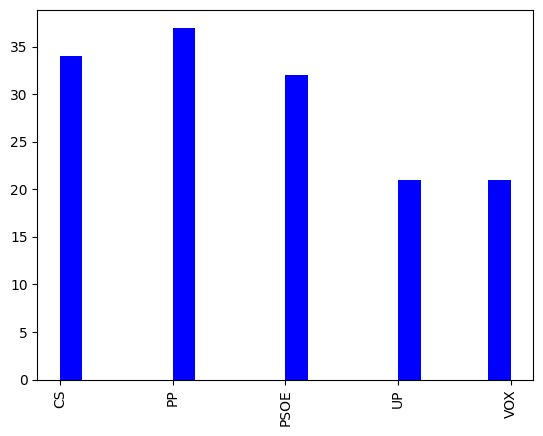

Cluster 1


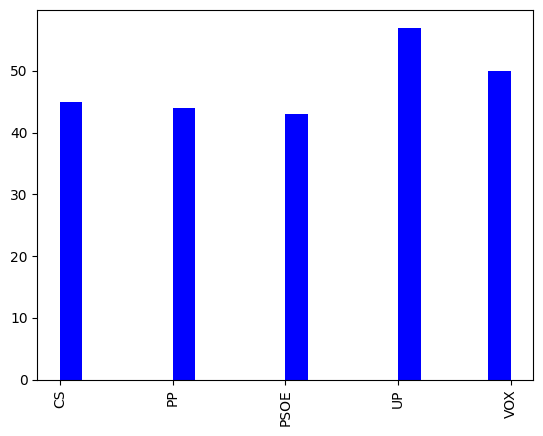

Cluster 2


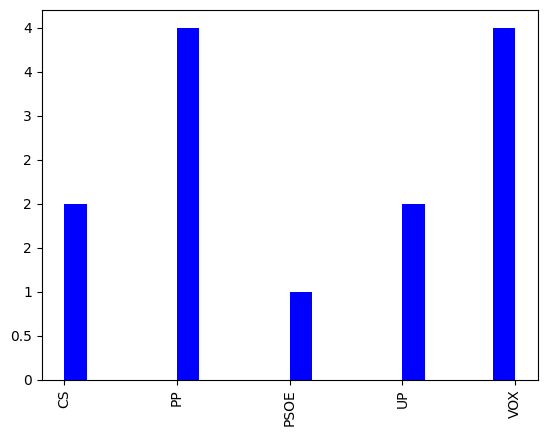

Cluster 3


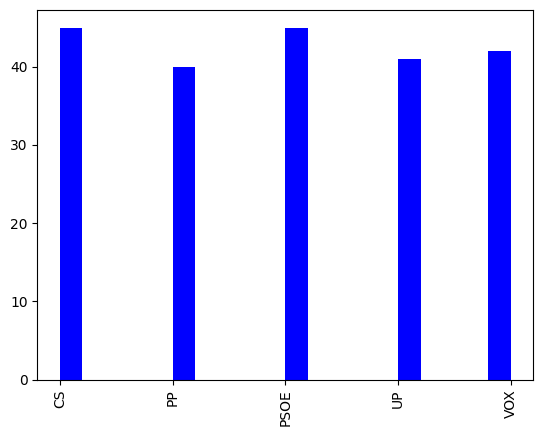

Cluster 4


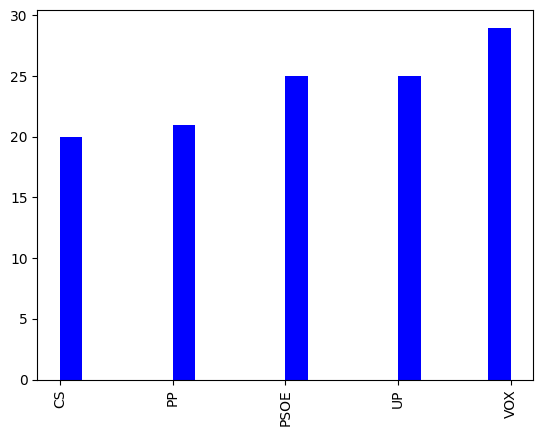

In [10]:
def histogram(df, col, bins=20, color="blue"):
    # labels = ["PSOE","PP","CS","UP","VOX"]
    labels = ["CS", "PP", "PSOE", "UP", "VOX"]
    fig, ax = plt.subplots()
    hist(ax, df.select([col]), bins=bins, color=[color])
    plt.xticks(range(5), labels, rotation="vertical")
    plt.show()


def show_clusters(predictions, k):
    # solution
    for c in range(k):
        print(f"Cluster {c}")
        df_c = predictions.filter(predictions.prediction == c)
        histogram(df_c, "label")


# test
show_clusters(predictions, k)

#### Ejercicio 3 [2 puntos]     

Los resultados son desalentadores:  las respuestas no permiten distinguir partidos ¿estamos haciendo algo mal?

Se nos ocurre que quizás el problema sea que hay que escalar los datos. Para ello usaremos el escalador MinMaxScaler, como paso adicional del pipeline, aplicándoselo a todos los campos excepto a `label`. De nuevo el resultado se llamará `predictions`.

Cluster 0


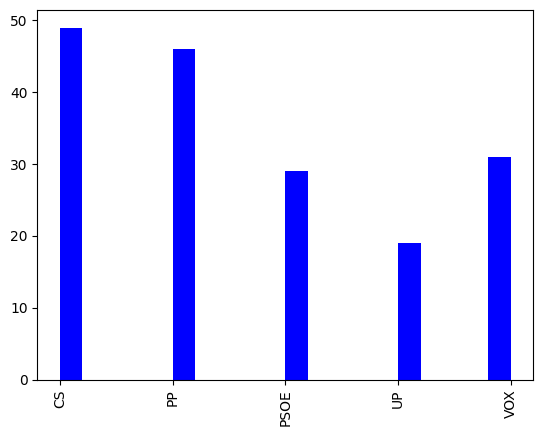

Cluster 1


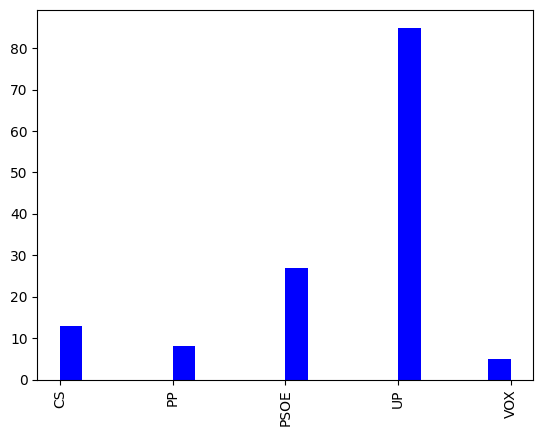

Cluster 2


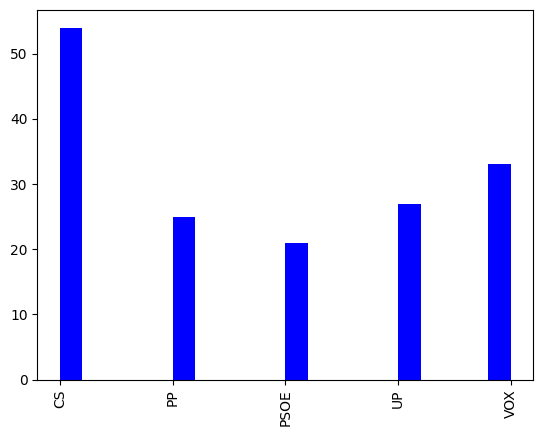

Cluster 3


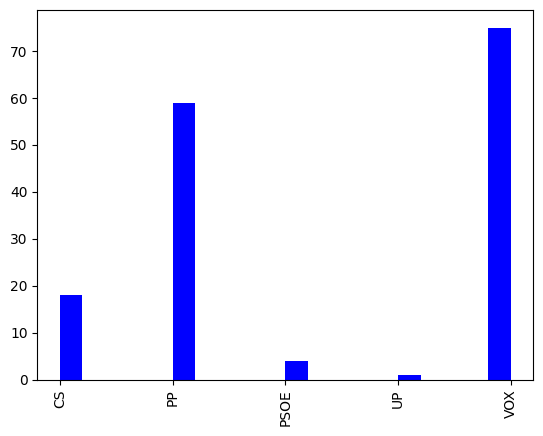

Cluster 4


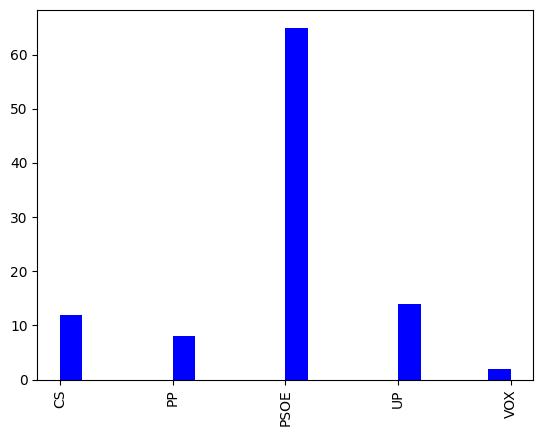

In [13]:
from pyspark.ml.feature import MinMaxScaler

# solution
assembler = VectorAssembler(inputCols=df.columns[:-1], outputCol="unscaledFeatures")
scaler = MinMaxScaler(inputCol="unscaledFeatures", outputCol="features")
pipeline = Pipeline(stages=[assembler, scaler, method])
model = pipeline.fit(df)
predictions = model.transform(df)

### test
show_clusters(predictions, k)

#### Ejercicio 4 [2 puntos]     

Esto está mejor, ahora parece que al menos algunos de los clúster corresponden claramente a algún partido o a dos partidos. 

Se nos ocurre una nueva idea: nos damos cuenta de que algunas preguntas no representan un valor ordinal (tipo "nada", "algo", "mucho") sino categórico, y por tanto no tiene sentido aplicarles el escalador. En su lugar le aplicaremos el transformador `OneHotEncoder`.

En el siguiente código, la variable `cols_codify` tiene el nombre de estas columnas y `cols_codify_newnames` son los nuevos nombres que recibirán las variables transformadas (salida de `OneHotEncoder`). Además, `vectorcols` es la lista de nombres de columna que debe utilizar el VectorAssembler, que contiene las variables categóricas ya reemplazadas por sus nuevos nombres.

Diseñar y aplicar el pipeline con todos los (4) elementos. El escalador se deja tal cual porque no afecta a las variables codificadas por OneHotEncoder y sí al resto.

Cluster 0


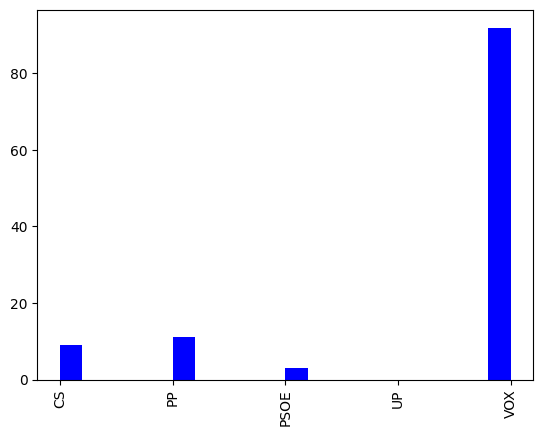

Cluster 1


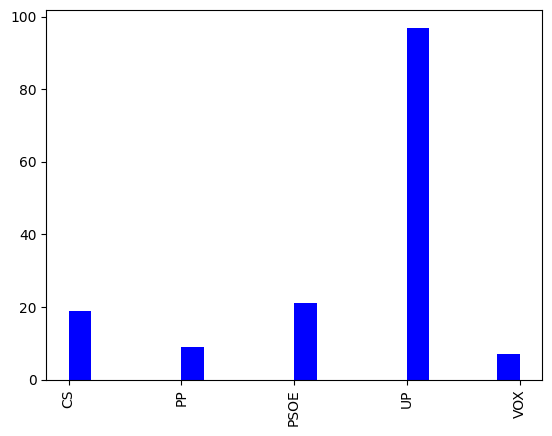

Cluster 2


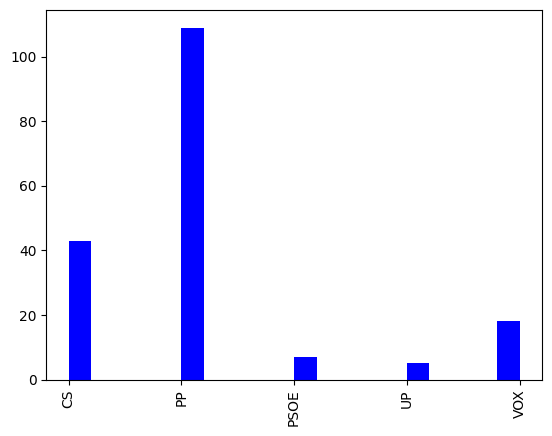

Cluster 3


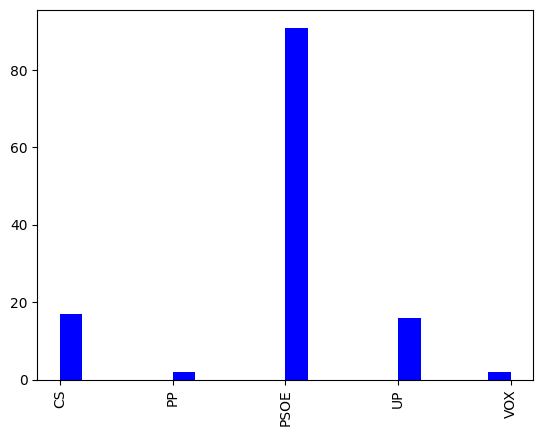

Cluster 4


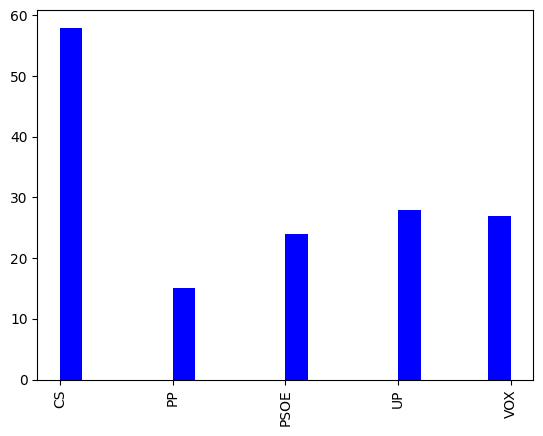

In [ ]:
from pyspark.ml.feature import OneHotEncoder

cols_codify = [
    "p5_1",
    "p5_2",
    "p5_3",
    "p5_4",
    "p5_5",
    "p5_6",
    "p5_7",
    "p5_8",
    "p5_9",
    "p5_10",
    "p5_11",
    "p5_12",
    "prov",
    "ccaa",
]
cols_codify_newnames = [x + "_t" for x in cols_codify]

vectorcols = [
    x if x not in cols_codify else x + "_t" for x in df.columns if x not in ["label"]
]

#### Solution
encoder = OneHotEncoder(inputCols=cols_codify, outputCols=cols_codify_newnames)
assembler = VectorAssembler(inputCols=vectorcols, outputCol="unscaledFeatures")
scaler = MinMaxScaler(inputCol="unscaledFeatures", outputCol="features")
pipeline = Pipeline(stages=[encoder, assembler, scaler, method])
model = pipeline.fit(df)
predictions = model.transform(df)

### test
show_clusters(predictions, k)

### Ejercicio 5 (2 puntos)

Visto que las preguntas sí parecen reflejar (más o menos) las posiciones de los partidos nos planteamos la pregunta ¿Podríamos predecir el voto en las últimas elecciones a partir del cuestionario?. Utilizar un clasificador NaiveBayes con hiperparámetro `modelType="bernoulli"` para deducir label a partir del resto de columnas. El dataframe con las predicciones del test se llamará `predictions`. 

Nota1: Hacerlo con un pipeline, se pueden reutilizar los pasos que se consideren

Nota2: Al utilizar la familia bernoulli solo se podrán utilizar las variables que han sido transformadas con OneHotEncoding, ya que este método requiere valores que solo pueden ser 0 o 1

Importante: Ahora sí que hay que utilizar train y test, estamos en aprendizaje supervisado

In [ ]:
from pyspark.ml.classification import NaiveBayes

# this is needed because raendomforest assumes that label is a double
from pyspark.sql.functions import col

df = df.withColumn("label", df.label.cast("double"))

# train  & test proportion
ratio_train = 0.65


#####solution
train, test = df.randomSplit([ratio_train, 1 - ratio_train])
encoder = OneHotEncoder(inputCols=cols_codify, outputCols=cols_codify_newnames)
assembler = VectorAssembler(inputCols=cols_codify_newnames, outputCol="features")
method = NaiveBayes(modelType="bernoulli")
pipeline = Pipeline(stages=[encoder, assembler, method])
model = pipeline.fit(train)
predictions = model.transform(test)

['CS', 'PP', 'PSOE', 'UP', 'VOX']
[[30. 12.  3.  1.  3.]
 [14. 34.  1.  1.  4.]
 [15.  2. 29.  4.  0.]
 [11.  0.  5. 33.  0.]
 [12.  3.  2.  0. 38.]]
Kappa 0.5481083738254144
